# **Final ConvNet Model Calculations**

From the previous notebooks, did some model design and selection (as well as considering different image channels). Found that a bigger model works with all the channels.

To prepare for the performance on the training data, because we also train our model on this, we can't really just train and report testing accuracy on the same set.

So we'll report the average of results evaluating on the test set in each fold of a k-fold cross validation.

---

*Note: the following was run on a Google CoLab Notebook*

In [0]:
%matplotlib inline

import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
import torch.optim as optim
from torch.utils.data import Dataset

import matplotlib.pyplot as plt

In [2]:
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

In [0]:
df_train_features = pd.read_csv('./hb_train_feature.csv')
df_test_features = pd.read_csv('./hb_test_feature.csv')
df_train_truth = pd.read_csv('./hb_train_truth.csv')

## **Load Data**

### **Define methods for data prep and payoff matrices**

In [0]:
def view_game_matrix(df_row):
    """
    View payoffs in 3x3 matrix format
    inputs
        df_row : Pandas series object, e.g. df.iloc[0]
    returns
        [row_payoffs, col_payoffs] : np.array (2x3x3)
    """
    return df_row.values.reshape(2, 3, 3)

def normalize(matrix):
    """
    Method to normalize a given matrix
    input:
        matrix : np.array, the payouts 
    output:
        np.array, the matrix normalized
    """
    min_val = np.min(matrix)
    max_val = np.max(matrix)
    return (matrix - min_val) / (max_val - min_val)
    
def get_payoff_matrices(df, rows_first=False, normalized=True):
    """
    Convert input dataframe into new normed payoff data
    input:
        df : pandas.DataFrame
        rows_first : bool, if true, separate data into first row payoffs and then columns, 
        otherwise row and col payoffs lumped next to each other
        normalized : bool, if true, normalize the matrices
    output:
        np.array, the converted data 
    """
    if normalized:
        df = df.apply(normalize, axis=0)
    matrices = np.zeros([2 * df.shape[0], 3, 3])
    for row_ix in range(df.shape[0]):
        payoffs = view_game_matrix(df.iloc[row_ix])
        if rows_first:
            matrices[row_ix] = payoffs[0]
            matrices[row_ix + df.shape[0]] = payoffs[1]
        else:
            matrices[row_ix * 2] = payoffs[0]
            matrices[row_ix * 2 + 1] = payoffs[1]
#     if normalized:
#         matrices = np.array([normalize(matrices[ix]) for ix in range(matrices.shape[0])])
    return matrices

def transform(payoffs, rotations):  # rotations = [2, 1, 0]
#     temp = norm_payoffs_c[:, 0]
    new_payoffs = np.zeros(payoffs.shape)
    for ix in range(len(rotations)):
        new_payoffs[:, ix] = payoffs[:, rotations[ix]]
    return new_payoffs

### **Generate matrices and augment data**

In [0]:
import itertools
orderings = list(itertools.permutations([0, 1, 2]))

In [0]:
# Get payoff matrices and augment
norm_payoffs = get_payoff_matrices(df_train_features, rows_first=True, normalized=True)
norm_payoffs_r = norm_payoffs[:250]
norm_payoffs_c = norm_payoffs[250:]

augmented_data = []
augmented_labels = []
for order in orderings:
    trans_payoffs_r = transform(norm_payoffs_r, order)
    trans_payoffs_c = transform(norm_payoffs_c, order)
    trans_freq = df_train_truth.apply(lambda x: x[list(order)], axis=1).values
    augmented_data.append(np.array([trans_payoffs_r, trans_payoffs_c]))
    augmented_labels.append(trans_freq)

In [0]:
game_data = np.array(augmented_data).transpose([0, 2, 1, 3, 4]).reshape(250 * 6, 2, 3, 3)
game_labels = np.array(augmented_labels).reshape(250 * 6, 3)

### **Generate more input features (channel dimensions)**

In [0]:
# Difference between the row and col payoffs
game_data_rc_diffs = game_data[:, 0, :, :] - game_data[:, 1, :, :]

# Difference between the payoff max and payoffs

## Get maxes
max_rows = np.max(game_data[:, 0, :, :], axis=(1, 2))
max_cols = np.max(game_data[:, 1, :, :], axis=(1, 2))

## Expand and convert to previous data shape
max_rows = np.repeat(max_rows, 9).reshape((1500, 3, 3))
max_cols = np.repeat(max_cols, 9).reshape((1500, 3, 3))

game_data_maxdiff_r = game_data[:, 0, :, :] - max_rows
game_data_maxdiff_c = game_data[:, 1, :, :] - max_cols

game_data_diffs = np.array([game_data_rc_diffs, game_data_maxdiff_r, game_data_maxdiff_c]).transpose(1, 0, 2, 3)
game_data_combined = np.concatenate([game_data, game_data_diffs], axis=1)
game_data_row = np.concatenate([np.expand_dims(game_data[:, 0, :, :], 1), game_data_diffs[:,0:2, :, :]], axis=1)

### **Define PyTorch Dataset Class**

In [0]:
class GameDataset(Dataset):
    """Bimatrix game dataset"""
    def __init__(self, data, labels):
        """
        Args:
            data: game payoffs; (num_samples, channels, row, col)
            labels: frequency of actions; (num_samples, freq)
        """
        self.samples = []
        self.data = data
        self.labels = labels
        self.load_samples()
        
    def __len__(self):
        return len(self.samples)

    def __getitem__(self, ix):
        return self.samples[ix]

    def load_samples(self):
        for ix in range(self.data.shape[0]):
            self.samples.append((
                torch.tensor(self.data[ix], dtype=torch.float).to(DEVICE), 
                torch.tensor(self.labels[ix], dtype=torch.float).to(DEVICE)))
            
def load_game_data(data, labels, batch_size, shuffle=True):
    torch.manual_seed(SEED)
    dataset = GameDataset(data, labels)
    dataloader = torch.utils.data.DataLoader(
        dataset, batch_size = batch_size, shuffle=shuffle)
    return dataloader

## **Model**

In [0]:
import torch.nn as nn  
import torch.nn.functional as F

In [0]:
class ConvNetPdBig(nn.Module):
    """
    ConvNet Model for all features data. Variable number of channels
    """
    def __init__(self, log_softmax=False, softmax=True, dropout=0., channels=3):
        super(ConvNetPdBig, self).__init__()
        self.log = log_softmax
        self.soft = softmax
        # Input: 3 channels, 8 output channels, 3x3 conv -> 8x3x3 output
        self.conv1 = nn.Conv2d(channels, 32, 3, padding=1) 
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)  
        self.fc1 = nn.Linear(128 * 3 * 3, 512)  
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 32)
        self.fc4 = nn.Linear(32, 3)  # Predict all three frequencies, use Softmax?
        self.log_softmax = nn.LogSoftmax(dim=1)
        self.softmax = nn.Softmax(dim=1)
        self.dropout_conv = nn.Dropout2d(p=0.1)
        self.dropout_fcn = nn.Dropout(p=dropout)
        self.gradients = None  # Placeholder for gradients

    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.dropout_conv(x)
        x = F.relu(self.conv2(x))
        x = self.dropout_conv(x)
        x = F.relu(self.conv3(x))
        # Hook to capture the gradients
        h = x.register_hook(self.activations_hook)
        x = self.dropout_conv(x)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = self.dropout_fcn(x)
        x = F.relu(self.fc2(x))
        x = self.dropout_fcn(x)
        x = F.relu(self.fc3(x))
        x = self.dropout_fcn(x)
        x = self.fc4(x)
        if self.log:
            return self.log_softmax(x)
        elif self.soft:
            return self.softmax(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # All dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    # Method for the gradient extraction
    def get_activations_gradient(self):
        return self.gradients
    
    # Method for the activation extraction
    def get_activations(self, x):
        activations = []
        x = F.relu(self.conv1(x))
        activations.append(x)
        x = self.dropout_conv(x)
        x = F.relu(self.conv2(x))
        activations.append(x)
        x = self.dropout_conv(x)
        x = F.relu(self.conv3(x))
        activations.append(x)
        return activations

## **Training**

### **Get splits for all data**

In [0]:
from sklearn.model_selection import KFold

In [0]:
np.random.seed(SEED)

# Shuffle data first
game_ix = list(range(len(game_data_combined)))
np.random.shuffle(game_ix)

game_data_combined_ = game_data_combined[game_ix]
game_labels_ = game_labels[game_ix]

In [14]:
game_data_combined_.shape

(1500, 5, 3, 3)

In [0]:
def get_splits(data, labels, num_splits):
    """
    Returns splits for data
    Output:
        Array of splits, each split = [train_data, train_labels, 
                                       test_data, test_labels]
    """
    splits = []
    kf = KFold(n_splits=NUM_SPLITS)
    for train_val_ix, test_ix in kf.split(data):
        train_val_data, test_data = np.array(data[train_val_ix]), np.array(data[test_ix])
        train_val_labels, test_labels = np.array(labels[train_val_ix]), np.array(labels[test_ix])
        splits.append([train_val_data, train_val_labels, test_data, test_labels])
    return splits

### **Define training methods**

In [0]:
def batch_quadratic_loss(batch_output, batch_label):
    loss = 0
    for ix in range(len(batch_output)):
        loss += np.sum([(batch_output[ix][i] - batch_label[ix][i]) ** 2. for i in range(3)])
    return loss
        

def evaluate(model, dataloader, model_softmax=False):
    softmax = nn.Softmax(dim=1)
    batch_quad_loss = 0
    outputs = []
    labels = []
    model.eval()
    for batch_ix, (data, label) in enumerate(dataloader):
        if model.soft:
            output = model(data)
        elif model.log:
            output = torch.exp(model(data))  # convert back regular probabilities
        else:
            output = softmax(model(data))
        batch_quad_loss += batch_quadratic_loss(output, label).cpu().detach().numpy()
        outputs.append(output.squeeze().cpu().detach().numpy())
        labels.append(label.squeeze().cpu().detach().numpy())

    val_actions = np.argmax(np.array(labels), axis=1)
    pred_actions = np.argmax(np.array(outputs), axis=1)
    action_acc = np.sum(val_actions == pred_actions) / val_actions.shape[0]

    return batch_quad_loss, action_acc, outputs

def train(model, loss_fn, dataloader, dataloader_val=None, epochs=200, 
          log_targets=False, model_softmax=True, log=5, log_softmax_outputs=False, 
          val_data=None, val_labels=None):

    # # Multiple criterion
    # mse_loss = nn.MSELoss()
    # ce_loss = nn.CrossEntropyLoss() 
    softmax_fn = nn.Softmax(dim=1)
    log_softmax_fn = nn.LogSoftmax(dim=1)

    dataloader_actual_val = load_game_data(val_data, val_labels, batch_size=1, shuffle=False)
    loss_total = []
    acc_total = []
    acc_total_val = []
    for epoch in range(epochs):  # tqdm is buggy sometimes
        epoch_loss = 0
        for batch_ix, (data, label) in enumerate(dataloader):
            # print(data.shape)
            output = model(data)
            # print(output)
            target = torch.tensor(np.argmax(np.array(label.cpu()), axis=1), dtype=torch.long).to(DEVICE)
            optimizer.zero_grad()
            # loss = 1.0 * mse_loss(softmax(output), label) + 0.0 * ce_loss(output, target)
            if log_targets:
                # output = log_softmax_fn(output)
                label = torch.log(label)
                # print(label)
            if log_softmax_outputs:
                output = log_softmax_fn(output)
                # print(output)
            elif not model_softmax:
                output = softmax_fn(output)
            loss = loss_fn(output, label)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        loss_total.append(epoch_loss)
        quad_loss, acc, _ = evaluate(model, dataloader_val, model_softmax=model_softmax)
        quad_loss_val, acc_val, _ = evaluate(model, dataloader_actual_val, model_softmax=model_softmax)
        if (epoch + 1) % log == 0:
            print('Epoch {0:<2} | Training Loss: {1:<2f} | Quad Loss: {2:<2f} | Acc: {3:<2f} | Val Quad Loss: {4:<2f} | Val Acc: {5:<2f}'.format(
                epoch, epoch_loss, quad_loss, acc, quad_loss_val, acc_val))
        acc_total.append(acc)
        acc_total_val.append(acc_val)
    return loss_total, [acc_total, acc_total_val]

## **Results**

Epoch 49 | Training Loss: 2.669887 | Quad Loss: 30.614367 | Acc: 0.872500 | Val Quad Loss: 13.515728 | Val Acc: 0.803333
Epoch 99 | Training Loss: 1.440084 | Quad Loss: 18.340009 | Acc: 0.917500 | Val Quad Loss: 13.789785 | Val Acc: 0.793333
Epoch 149 | Training Loss: 1.111815 | Quad Loss: 11.631279 | Acc: 0.931667 | Val Quad Loss: 12.637930 | Val Acc: 0.800000
Epoch 199 | Training Loss: 0.856875 | Quad Loss: 13.295963 | Acc: 0.929167 | Val Quad Loss: 12.562014 | Val Acc: 0.810000


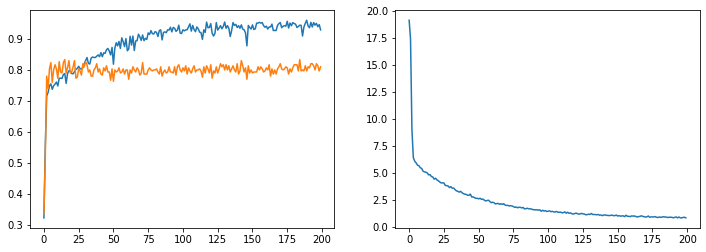

12.562014172402996 0.81
Epoch 49 | Training Loss: 3.101837 | Quad Loss: 34.373152 | Acc: 0.862500 | Val Quad Loss: 12.229519 | Val Acc: 0.810000
Epoch 99 | Training Loss: 1.723221 | Quad Loss: 20.933011 | Acc: 0.915833 | Val Quad Loss: 11.713355 | Val Acc: 0.823333
Epoch 149 | Training Loss: 1.094739 | Quad Loss: 11.141231 | Acc: 0.945000 | Val Quad Loss: 12.210544 | Val Acc: 0.836667
Epoch 199 | Training Loss: 0.864364 | Quad Loss: 9.304938 | Acc: 0.952500 | Val Quad Loss: 11.514870 | Val Acc: 0.803333


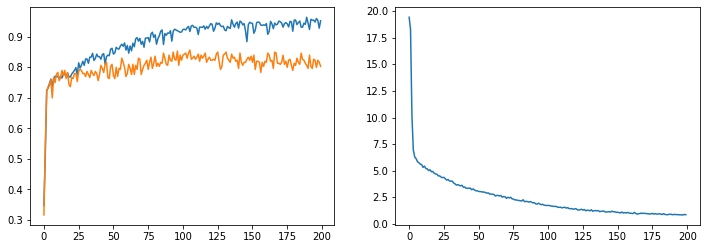

11.51486989951809 0.8033333333333333
Epoch 49 | Training Loss: 2.930250 | Quad Loss: 33.748443 | Acc: 0.874167 | Val Quad Loss: 13.158216 | Val Acc: 0.813333
Epoch 99 | Training Loss: 1.794744 | Quad Loss: 21.662681 | Acc: 0.906667 | Val Quad Loss: 13.250376 | Val Acc: 0.833333
Epoch 149 | Training Loss: 1.188585 | Quad Loss: 12.570838 | Acc: 0.923333 | Val Quad Loss: 12.686702 | Val Acc: 0.843333
Epoch 199 | Training Loss: 0.932929 | Quad Loss: 10.119405 | Acc: 0.945833 | Val Quad Loss: 13.252686 | Val Acc: 0.806667


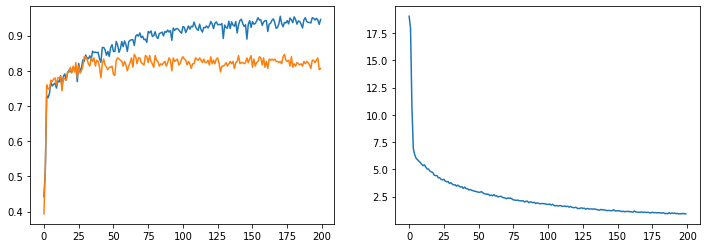

13.252685587620363 0.8066666666666666
Epoch 49 | Training Loss: 2.920183 | Quad Loss: 31.581554 | Acc: 0.875833 | Val Quad Loss: 13.482668 | Val Acc: 0.773333
Epoch 99 | Training Loss: 1.629124 | Quad Loss: 19.214875 | Acc: 0.917500 | Val Quad Loss: 13.745515 | Val Acc: 0.780000
Epoch 149 | Training Loss: 1.056688 | Quad Loss: 11.304186 | Acc: 0.940000 | Val Quad Loss: 12.901363 | Val Acc: 0.790000
Epoch 199 | Training Loss: 0.802680 | Quad Loss: 8.017121 | Acc: 0.951667 | Val Quad Loss: 12.655135 | Val Acc: 0.786667


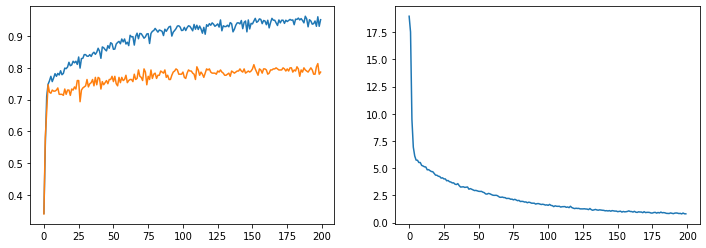

12.65513466813718 0.7866666666666666
Epoch 49 | Training Loss: 2.920210 | Quad Loss: 33.574234 | Acc: 0.856667 | Val Quad Loss: 17.299863 | Val Acc: 0.753333
Epoch 99 | Training Loss: 1.566422 | Quad Loss: 16.261259 | Acc: 0.929167 | Val Quad Loss: 16.646950 | Val Acc: 0.763333
Epoch 149 | Training Loss: 0.966776 | Quad Loss: 10.277917 | Acc: 0.932500 | Val Quad Loss: 16.633680 | Val Acc: 0.790000
Epoch 199 | Training Loss: 0.762714 | Quad Loss: 7.218948 | Acc: 0.960000 | Val Quad Loss: 16.050191 | Val Acc: 0.796667


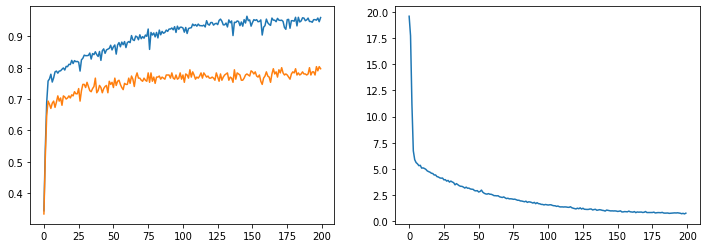

16.050191097347124 0.7966666666666666


In [38]:
criterion = nn.MSELoss()
EPOCHS = 200
LOG = 50
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
NUM_SPLITS = 5

# Prepare splits
splits = get_splits(game_data_combined_, game_labels_, NUM_SPLITS)

for ix, split in enumerate(splits):
    train_val_data = split[0]
    train_val_labels = split[1]
    test_data = split[2]
    test_labels = split[3]

    # Actually train
    model_all_mse = ConvNetPdBig(log_softmax=False, softmax=True, dropout=0.5, channels=5)
    model_all_mse = model_all_mse.to(DEVICE)

    optimizer = optim.Adam(model_all_mse.parameters(), lr=1e-4, weight_decay=0.0001)

    dataloader = load_game_data(train_val_data, train_val_labels, batch_size=4, shuffle=True)

    dataloader_val = load_game_data(train_val_data, train_val_labels, batch_size=1, shuffle=False)
    losses_all_mse, acc_all_mse = train(model_all_mse, criterion, dataloader, dataloader_val, epochs=EPOCHS, 
                                        log_targets=False, model_softmax=True, log=LOG, 
                                        val_data=test_data, val_labels=test_labels)

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(acc_all_mse[0])
    plt.plot(acc_all_mse[1])
    plt.subplot(1, 2, 2)
    plt.plot(losses_all_mse)
    plt.show()

    dataloader_val = load_game_data(test_data, test_labels, batch_size=1, shuffle=False)
    batch_ql, acc, predictions = evaluate(model_all_mse, dataloader_val)
    print(batch_ql, acc)

    torch.save(model_all_mse.state_dict(), './model_all_mse_200_s={}_split={}.pt'.format(SEED, ix))

### **Evaluation Metrics**

In [39]:
# Average quadratic loss:
quad_losses = [12.562014172402996, 
               11.51486989951809,
               13.252685587620363,
               13.252685587620363,
               16.050191097347124]
print('Avg Quad Loss: {}'.format(np.sum(quad_losses) / len(quad_losses)))

accuracies = [0.81, 
              0.8033333333333333, 
              0.8066666666666666, 
              0.8066666666666666, 
              0.7966666666666666]
print('Avg Acc: {}'.format(np.sum(accuracies) / len(accuracies)))              

Avg Quad Loss: 13.326489268901787
Avg Acc: 0.8046666666666666


### **Visualization**

#### **Define G-CAM methods**

In [0]:
def get_cam_heatmaps(model, layer, dataloader, indices):
    model.eval()

    samples = []
    labels = []
    heatmaps = []
    predictions = []

    for batch_ix, (data, label) in enumerate(dataloader):
        samples.append(data)
        labels.append(np.round(label.detach().cpu().numpy().squeeze(), decimals=3))

    selected_samples = [samples[ix] for ix in range(len(samples)) if ix in indices]
    for sample in selected_samples:
        pred = model(sample)
        target = pred.argmax(dim=1)

        # Get gradient of output wrt model params
        pred[:, target].backward()
        # Pull gradients out of model
        gradients = model.get_activations_gradient()

        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3]) # Pool grads across channels
        activations = model.get_activations(data)
        activations = activations[layer].detach()  # Get activations of last conv layer
        # Weight channel activations by gradients
        for i in range(activations.shape[1]):
            activations[:, i, :, :] *= pooled_gradients[i]

        # Calculate heatmap valules
        heatmap = torch.mean(activations, dim=1).squeeze()

        # ReLU on heatmap
        zeros = torch.zeros(heatmap.shape).cuda()
        heatmap = torch.max(heatmap, zeros)  # ReLU on heatmap
        heatmap /= torch.max(heatmap)  # Normalize
        heatmaps.append(heatmap)
        predictions.append(pred.detach().cpu().numpy().squeeze())
    return heatmaps, [labels[ix] for ix in range(len(labels)) if ix in indices], predictions


In [0]:
def visualize_heatmaps(heatmaps, labels, predictions, data, show_payoffs=False, diff_data=None, show_diffs=False):
    if data.shape[0] == 9:
        fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 10))
        fig.subplots_adjust(hspace=0.4, wspace=0)
        fontsize = 8
    else:
        n_rows = 2
        n_cols = int(data.shape[0] / n_rows)
        fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, 
                                 figsize=(n_cols * 7, n_rows * 6))
        fig.subplots_adjust(hspace=0.4, wspace=0)
        fontsize = 18

    selected_data = data

    for ix, ax in enumerate(axes.flat):
        viz = ax.matshow(heatmaps[ix].squeeze().detach().cpu().numpy())
        ax.set_yticklabels([])
        ax.set_xticklabels([])
        # ax.text('test', ha='center', va='center')
        if show_payoffs:
            for i in range(selected_data.shape[2]):
                for j in range(selected_data.shape[2]):
                    color = 'w' if heatmaps[ix][i, j] < 0.4 else 'b'  # visibility
                    text = ax.text(j, i, '({}, {})'.format(int(selected_data[ix][0][i, j] * 100),
                                                          int(selected_data[ix][1][i, j] * 100)), 
                                  ha="center", va="center", color=color, 
                                   fontsize=fontsize) 
                    
        elif show_diffs:
            for i in range(diff_data.shape[2]):
                for j in range(diff_data.shape[2]):
                    color = 'w' if heatmaps[ix][i, j] < 0.4 else 'b'  # visibility
                    text = ax.text(j, i, '({:.2f}, {:.2f})'.format(diff_data[ix][0][i, j],
                                                           diff_data[ix][1][i, j]), 
                                   ha="center", va="center", color=color, fontsize=7) 

        pred_str = [np.round(pred, 3) for pred in predictions[ix]]
        ax.set_title('{}\n{}'.format(labels[ix], pred_str), fontsize=fontsize)

    fig.colorbar(viz, ax=axes.ravel().tolist())
    plt.show()

## **Evaluate on original dataset**

Note these results are probably better than they should be, because we shuffled our data, so it probably includes some of these original data points.

In [0]:
# Original dataset without the augmetations
game_data_combined_og = game_data_combined[:250,:,:,:]
game_labels_og = game_labels[:250,:]

dataloader_og = load_game_data(game_data_combined_og, game_labels_og, 
                               batch_size=1, shuffle=False)

In [76]:
## Find worst split
predictions_by_split = []
for split in range(5):
    # Load Model
    model = ConvNetPdBig(softmax=True, dropout=0.5, channels=5)
    model.load_state_dict(
        torch.load('./model_all_mse_200_s=42_split={}.pt'.format(split)))
    model.to(DEVICE)
    model.eval()

    batch_ql, acc, predictions = evaluate(model, dataloader_og)
    predictions_by_split.append(np.array(predictions).squeeze())
    print('Split: {}, quad_loss: {}, acc: {}'.format(split, batch_ql, acc))

Split: 0, quad_loss: 4.752289749139891, acc: 0.9
Split: 1, quad_loss: 3.4834541272357455, acc: 0.932
Split: 2, quad_loss: 3.7992647915925772, acc: 0.948
Split: 3, quad_loss: 3.6060824007745396, acc: 0.912
Split: 4, quad_loss: 4.12811582555878, acc: 0.936


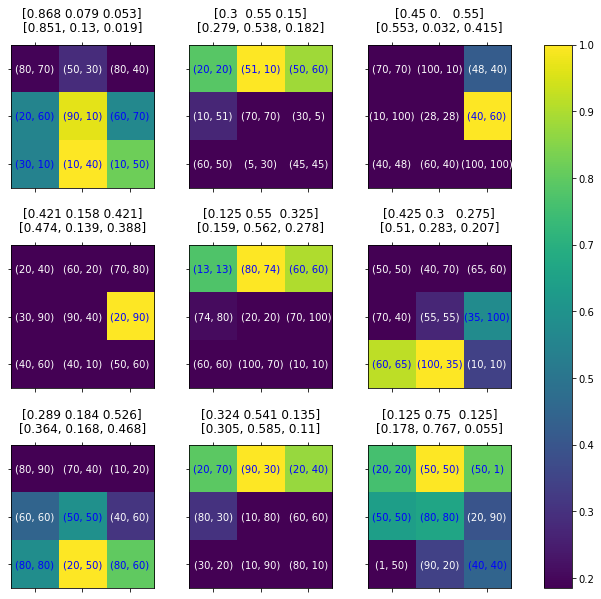

In [69]:
# Actually visualize
split = 0
model = ConvNetPdBig(softmax=True, dropout=0.5, channels=5)
model.load_state_dict(
    torch.load('./model_all_mse_200_s=42_split={}.pt'.format(split)))
model.to(DEVICE)
model.eval()

indices = list(range(0, 9))

heatmaps, labels, predictions = get_cam_heatmaps(model, -1, dataloader_og, indices=indices)
visualize_heatmaps(heatmaps, labels, predictions, data=game_data[indices], show_payoffs=True, 
                   diff_data=game_data_diffs[indices], show_diffs=False)

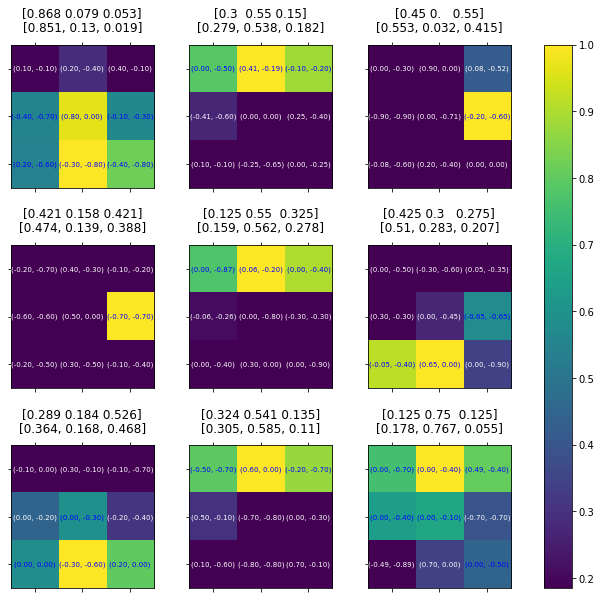

In [64]:
visualize_heatmaps(heatmaps, labels, predictions, data=game_data[indices], show_payoffs=False, 
                   diff_data=game_data_diffs[indices], show_diffs=True)

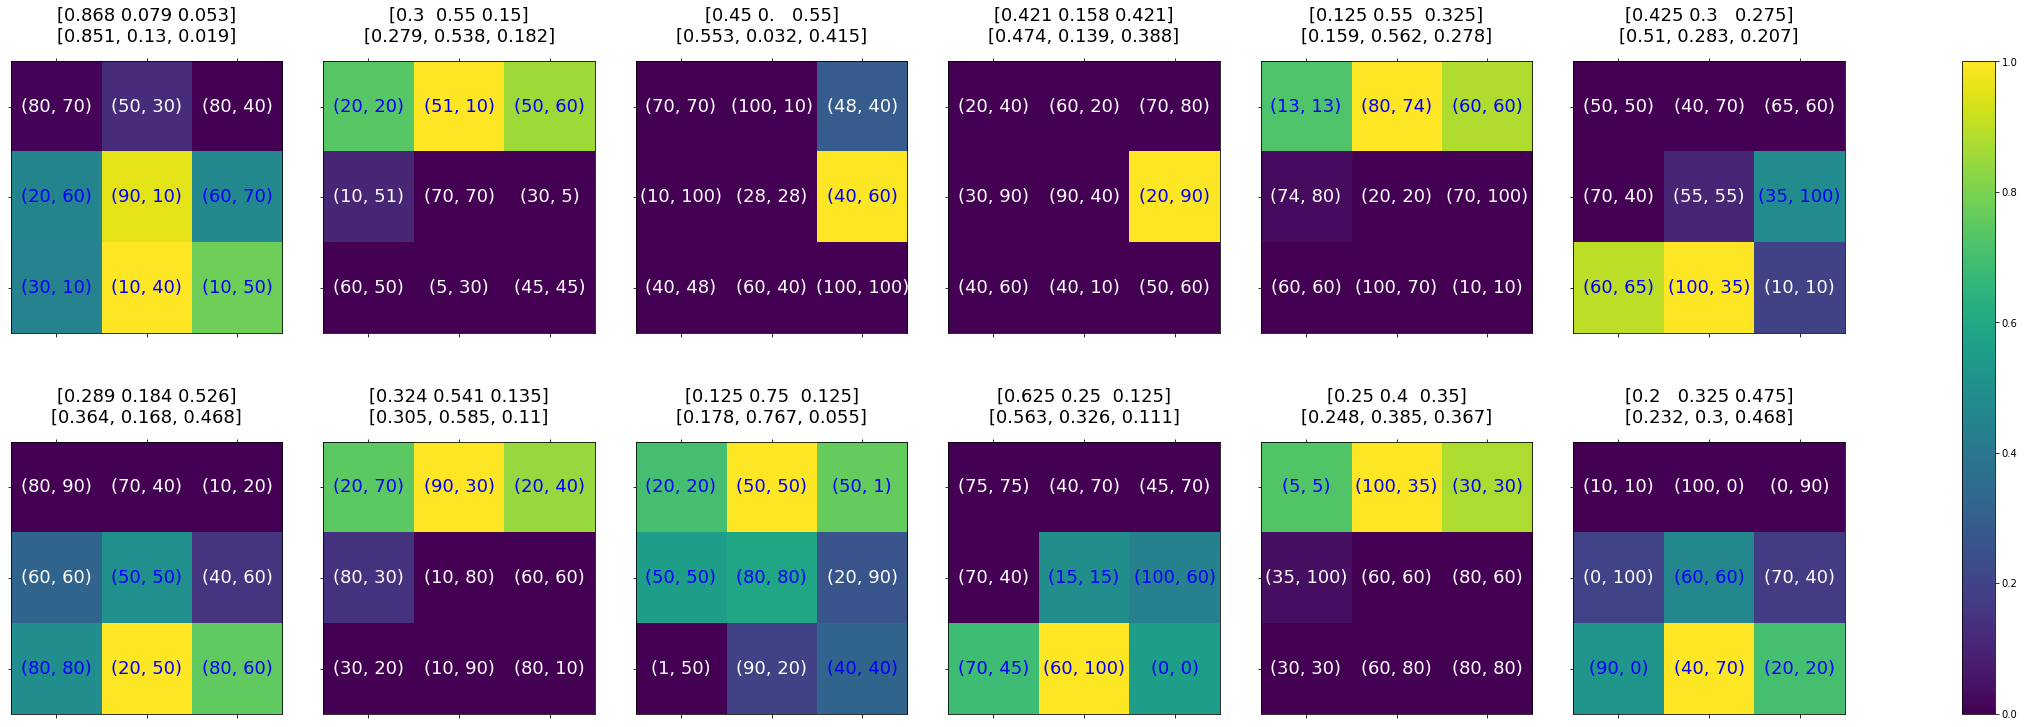

In [166]:
# Actually visualize
split = 0
model = ConvNetPdBig(softmax=True, dropout=0.5, channels=5)
model.load_state_dict(
    torch.load('./model_all_mse_200_s=42_split={}.pt'.format(split)))
model.to(DEVICE)
model.eval()

indices = list(range(0, 12))

heatmaps, labels, predictions = get_cam_heatmaps(model, -1, dataloader_og, indices=indices)
visualize_heatmaps(heatmaps, labels, predictions, data=game_data[indices], show_payoffs=True, 
                   diff_data=game_data_diffs[indices], show_diffs=False)

### **Frequency Distributions**

In [0]:
pred_dfs_by_split = []
for ix, split in enumerate(predictions_by_split):
    df = pd.DataFrame(split, 
                      columns=['f1', 'f2', 'f3'])
    pred_dfs_by_split.append(df)
    df.to_csv('hb_train_truth_predicted_split={}.csv'.format(ix), index=False)

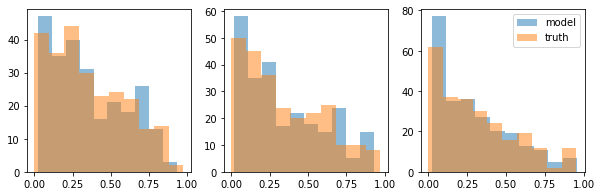

In [110]:
plt.figure(figsize=(10, 3))
plt.subplot(1, 3, 1)
plt.hist(df['f1'], alpha=0.5, label='model')
plt.hist(df_train_truth['f1'], alpha=0.5, label='truth')
plt.subplot(1, 3, 2)
plt.hist(df['f2'], alpha=0.5, label='model')
plt.hist(df_train_truth['f2'], alpha=0.5, label='truth')
plt.subplot(1, 3, 3)
plt.hist(df['f3'], alpha=0.5, label='model')
plt.hist(df_train_truth['f3'], alpha=0.5, label='truth')
plt.legend()
plt.show()

#### **Breakdown with clustering**

Use K-means clustering to identify game clusters based on the combined features, and organize the frequencies this way.

In [0]:
def plot_clustered_freq(df_train_truth, df_train_pred, cluster):
    filtered_df_gt = df_train_truth[df_train_truth.index.isin(
        [x[1] for x in clustered_games[cluster]])] * 10
    filtered_df_pd = df_train_pred[df_train_pred.index.isin(
        [x[1] for x in clustered_games[cluster]])] * 10
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 3, 1)
    plt.hist(filtered_df_pd['f1'], density=True, alpha=0.5, label='model')
    plt.hist(filtered_df_gt['f1'], density=True, alpha=0.5, label='truth')
    plt.xlim(xmin=-1, xmax = 11)
    plt.subplot(1, 3, 2)
    plt.hist(filtered_df_pd['f2'], density=True, alpha=0.5, label='model')
    plt.hist(filtered_df_gt['f2'], density=True, alpha=0.5, label='truth')
    plt.xlim(xmin=-1, xmax = 11)
    plt.subplot(1, 3, 3)
    plt.hist(filtered_df_pd['f3'], density=True, alpha=0.5, label='model')
    plt.hist(filtered_df_gt['f3'], density=True, alpha=0.5, label='truth')
    plt.xlim(xmin=-1, xmax = 11)
    plt.legend()
    plt.show()
    

In [0]:
from sklearn.cluster import KMeans

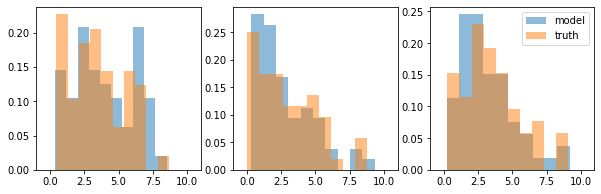

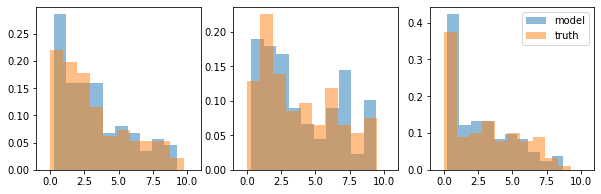

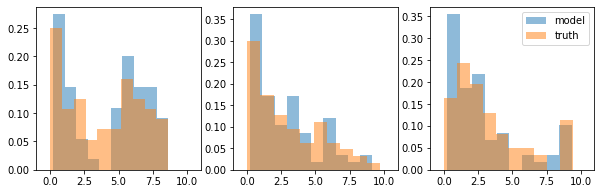

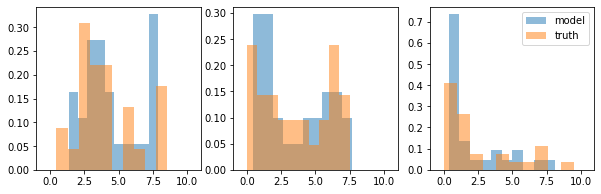

In [134]:
NUM_CLUSTERS = 4

kmeans = KMeans(n_clusters=NUM_CLUSTERS, ).fit(
    game_data_combined_og.reshape(250, -1))

clustered_games = {}

for ix in range(len(kmeans.labels_)):
    label = kmeans.labels_[ix]
    if label in clustered_games:
        clustered_games[label].append((game_data_combined_og[ix], ix))
    else:
        clustered_games[label] = [(game_data_combined_og[ix], ix)]

for c in range(NUM_CLUSTERS):
    plot_clustered_freq(df_train_truth, pred_dfs_by_split[0], c)

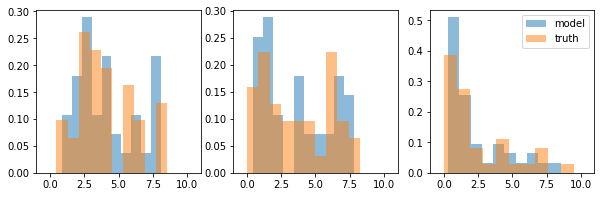

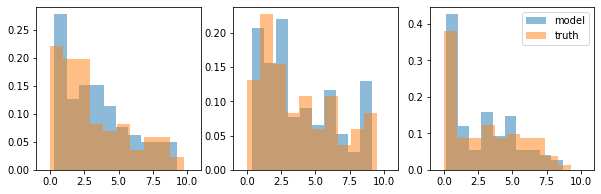

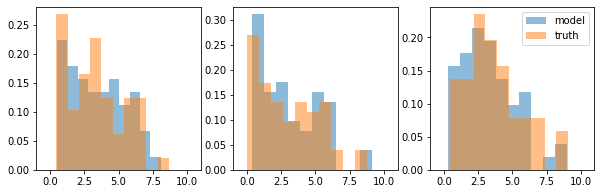

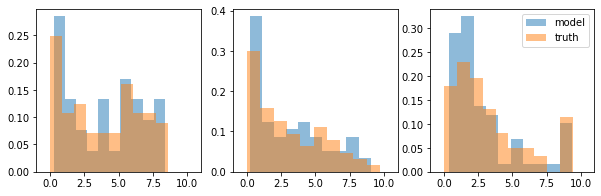

In [139]:
NUM_CLUSTERS = 4

kmeans = KMeans(n_clusters=NUM_CLUSTERS, ).fit(
    game_data_combined_og.reshape(250, -1))

clustered_games = {}

for ix in range(len(kmeans.labels_)):
    label = kmeans.labels_[ix]
    if label in clustered_games:
        clustered_games[label].append((game_data_combined_og[ix], ix))
    else:
        clustered_games[label] = [(game_data_combined_og[ix], ix)]

for c in range(NUM_CLUSTERS):
    plot_clustered_freq(df_train_truth, pred_dfs_by_split[1], c)